In [1]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
HERE = Path("/Users/USER/PycharmProjects/molecule")
DATA = HERE / "data"

In [78]:
def num_heavy_atoms(qm9_data: Data) -> int:
    return (qm9_data.z != 1).sum()

qm9_dataset = QM9(
    DATA,
    pre_filter=lambda data: num_heavy_atoms(data) < 9
)

mx = 0
for d in qm9_dataset:
    mx = max(mx, d.z.shape[0])

data_sample = qm9_dataset[0]
data_sample.pos.round(decimals=3)
data_sample.y
len(qm9_dataset)

21800

tensor([[5., 2., 2., 2., 2.],
        [2., 2., 1., 1., 1.],
        [2., 1., 2., 1., 1.],
        [2., 1., 1., 2., 1.],
        [2., 1., 1., 1., 2.]], device='cuda:0')

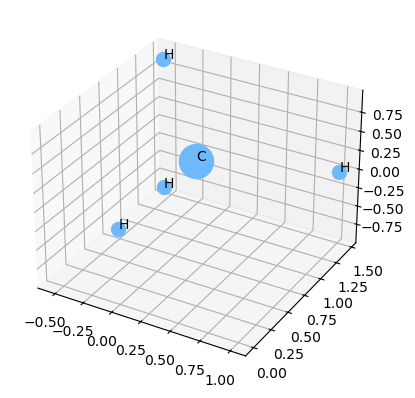

In [84]:
import periodictable as pt

def adjacency_matrix(z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
    am = torch.zeros(z.shape[0], z.shape[0])
    for idx in range(edge_index.shape[1]):
        print(int(edge_index[0, idx]), int(edge_index[1, idx]))
        am[int(edge_index[0, idx]), int(edge_index[1, idx])] = 1.0
        am[int(edge_index[1, idx]), int(edge_index[0, idx])] = 1.0
    return am
    
def distance_matrix(z: torch.Tensor, pos: torch.Tensor) -> torch.Tensor:
    dm = torch.zeros(z.shape[0], z.shape[0])
    for idx1 in range(z.shape[0]):
        for idx2 in range(z.shape[0]):
            coord1 = pos[idx1]
            coord2 = pos[idx2]
            dist = (coord1 - coord2).pow(2).sum().sqrt().item()
            dm[idx1, idx2] = dist
            dm[idx2, idx1] = dist
    return dm

def display_molecule(pos: torch.Tensor, z: torch.Tensor):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    coord = pos.numpy()
    for i in range(z.size(0)):
        ax.scatter(coord[i, 0], coord[i, 1], coord[i, 2], s=100*z[i].item(), c="#6EB9FC")
        ax.text(coord[i, 0], coord[i, 1], coord[i, 2], "{}".format(pt.elements[z[i].item()].symbol), zorder=100)

data_sample = qm9_dataset[0]
ea = data_sample.edge_attr
(ea[:, 0] + 2*ea[:, 1] + 3*ea[:, 2]).int()
# theta = 0
# for i in range(data_sample.pos.shape[0]):
#     rot = torch.tensor([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0],[0, 0, 1]]).float().to(device)
#     data_sample.pos[i] = torch.mm(rot, data_sample.pos[i].reshape(-1,1).to(device)).reshape(1,-1)
display_molecule(data_sample.pos, data_sample.z)
from torch_geometric.utils import to_dense_adj
am = to_dense_adj(data_sample.edge_index).squeeze().to(device)
am += torch.eye(am.shape[0]).to(device)
torch.mm(am, am)

In [74]:
import torch.nn as nn

data_list = torch.load('data_edge_attr.pt', map_location=lambda storage, loc: storage.cuda(0))
"""data_list = []
cnt = 0

for dt in qm9_dataset:
    dist_m = distance_matrix(dt.z, dt.pos)
    ea = dt.edge_attr
    # node level
    pad = nn.ZeroPad1d((0, mx-dist_m.shape[0]))
    data_list.append(
        Data(
            x=dt.z.reshape([-1, 1]).float(), 
            edge_index=dt.edge_index, 
            y=pad(dist_m), 
            edge_attr=(ea[:, 0] + 2*ea[:, 1] + 3*ea[:, 2]).int()
        )
    )

    cnt += 1
    if cnt % 1000 == 0:
        print(cnt)
    # graph level
    # dist_l = pad(dist_m).flatten()
    # data_list.append(Data(x=dt.z.reshape([-1, 1]).float(), edge_index=dt.edge_index, y=dist_l))"""

mx = 0
for d in data_list:
    mx = max(mx, d.x.shape[0])

KeyboardInterrupt: 

In [29]:
# torch.save(data_list, "data_edge_attr.pt")

In [5]:
from torch_geometric.utils import to_dense_adj
cnt = 0
for dt in data_list:
    am = to_dense_adj(dt.edge_index).squeeze()
    am += torch.eye(am.shape[0])
    am = torch.mm(am, torch.mm(am, am))
    pad = nn.ZeroPad1d((0, mx-am.shape[0]))
    am = pad(am)
    dt.y = dt.y * (am > 0)
    
    cnt += 1
    if cnt % 1000 == 0:
        print(cnt)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [6]:
l = len(data_list)
train_l = data_list[:l*4//5]
val_l = data_list[l*4//5+1:l*9//10]
test_l = data_list[l*9//10+1:l]

batch = 128
train_loader = DataLoader(train_l, batch_size=batch, shuffle=True, generator=torch.Generator(device='cuda'))
val_loader = DataLoader(val_l, batch_size=batch, shuffle=True, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(test_l, batch_size=batch, shuffle=True, generator=torch.Generator(device='cuda'))

In [10]:
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GraphConv, GINEConv, GINConv
from torch_geometric.nn import RGCNConv, RGATConv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

class RGCN(torch.nn.Module):
    def __init__(self, dim_in: int, dim_hidden: int, dim_out: int):
        super().__init__()
        self.conv1 = RGCNConv(dim_in, dim_hidden, 4)
        self.conv2 = RGCNConv(dim_hidden, dim_hidden, 4)
        self.conv4 = RGCNConv(dim_hidden, dim_hidden, 4)
        self.conv3 = RGCNConv(dim_hidden, dim_out, 4)
        self.lin = torch.nn.Linear(dim_hidden, dim_out)

    
    def forward(self, x: torch.Tensor, edge_idx: torch.Tensor, edge_type: torch.Tensor) -> torch.Tensor:
        output = self.conv1(x, edge_idx, edge_type)
        output = output.relu()
        output = self.conv2(output, edge_idx, edge_type)
        output = output.relu()
        output = self.conv4(output, edge_idx, edge_type)
        output = output.relu()
        # output = F.dropout(output, p=0.5, training=self.training)
        output = self.conv3(output, edge_idx, edge_type)
        # output = global_mean_pool(output, None)
        # output = self.lin(output)
        return output

class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_in: int, dim_hidden: int, dim_out: int):
        """Initializing GIN class

        Args:
            dim_hidden (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(dim_in, dim_hidden), BatchNorm1d(dim_hidden), ReLU(), Linear(dim_hidden, dim_hidden), ReLU()
            )
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), ReLU(), Linear(dim_hidden, dim_hidden), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), ReLU(), Linear(dim_hidden, dim_hidden), ReLU()
            )
        )
        self.conv4 = GINConv(
            Sequential(
                Linear(dim_hidden, dim_hidden), BatchNorm1d(dim_hidden), ReLU(), Linear(dim_hidden, dim_out), ReLU()
            )
        )
        self.lin1 = Linear(dim_hidden, dim_hidden)
        self.lin2 = Linear(dim_hidden, 1)

    def forward(self, x: torch.Tensor, edge_idx: torch.Tensor, edge_type: torch.Tensor):

        # Node embeddings
        h = self.conv1(x, edge_idx)
        h = h.relu()
        h = self.conv2(h, edge_idx)
        h = h.relu()
        h = self.conv3(h, edge_idx)
        h = h.relu()
        h = self.conv4(h, edge_idx)

        return h
    

In [11]:
def mask(data_y):
    return (data_y != 0).float()

def train(model, criterion):
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)
    
    model.train()
    loss = 0
    for d in train_loader:
        optimizer.zero_grad()
        
        output = model(d.x, d.edge_index, d.edge_attr.long())
        l = (criterion(output, d.y) * mask(d.y)).mean()
        loss += l / len(train_loader)
        l.backward()
        optimizer.step()
    return loss, model

def validate(model, criterion):
    
    model.eval()
    v_loss = 0
    for d in val_loader:
        output = model(d.x, d.edge_index, d.edge_attr.long())
        l = (criterion(output, d.y) * mask(d.y)).mean()
        v_loss += l / len(val_loader)
    return v_loss
        
@torch.no_grad()
def test(model, criterion):
    t_loss = 0
    for d in test_loader:
        output = model(d.x, d.edge_index, d.edge_attr.long())
        l = (criterion(output, d.y) * mask(d.y)).mean()
        t_loss += l / len(test_loader)
    return t_loss

def train_epoch(epoch, model, criterion):
    for e in range(epoch):
        e_loss, model = train(model, criterion)
        v_loss = validate(model, criterion)
        
        if e % 2 == 0:
            print(f"Epoch: {e}, train_loss: {e_loss.item()}, val_loss: {v_loss.item()}")

In [13]:
epochs = 50
model = GIN(dim_in=1, dim_hidden=256, dim_out=mx)
train_epoch(epochs, model, torch.nn.L1Loss())

Epoch: 0, train_loss: 0.20165888965129852, val_loss: 0.24040007591247559
Epoch: 2, train_loss: 0.1836566925048828, val_loss: 0.25456953048706055
Epoch: 4, train_loss: 0.17911873757839203, val_loss: 0.22198040783405304
Epoch: 6, train_loss: 0.1752350628376007, val_loss: 0.23009876906871796
Epoch: 8, train_loss: 0.17369195818901062, val_loss: 0.22431714832782745
Epoch: 10, train_loss: 0.17256410419940948, val_loss: 0.2258090227842331
Epoch: 12, train_loss: 0.17165565490722656, val_loss: 0.23322933912277222
Epoch: 14, train_loss: 0.17071549594402313, val_loss: 0.21768638491630554
Epoch: 16, train_loss: 0.17038030922412872, val_loss: 0.22430075705051422
Epoch: 18, train_loss: 0.16972284018993378, val_loss: 0.24307328462600708
Epoch: 20, train_loss: 0.16940611600875854, val_loss: 0.22519551217556
Epoch: 22, train_loss: 0.16900138556957245, val_loss: 0.2289503514766693
Epoch: 24, train_loss: 0.1686537116765976, val_loss: 0.21494902670383453
Epoch: 26, train_loss: 0.16859254240989685, val_los

KeyboardInterrupt: 

In [ ]:
""" MAE
Epoch: 0, train_loss: 0.10070610046386719, val_loss: 0.17367368936538696
Epoch: 2, train_loss: 0.09153222292661667, val_loss: 0.16136962175369263
Epoch: 4, train_loss: 0.0889720767736435, val_loss: 0.1558695137500763
Epoch: 6, train_loss: 0.0884355679154396, val_loss: 0.15434446930885315
Epoch: 8, train_loss: 0.08801628649234772, val_loss: 0.15186604857444763
Epoch: 10, train_loss: 0.08779668062925339, val_loss: 0.15405136346817017
Epoch: 12, train_loss: 0.08752492070198059, val_loss: 0.15571683645248413
Epoch: 14, train_loss: 0.0873148962855339, val_loss: 0.1521127074956894
Epoch: 16, train_loss: 0.08727260679006577, val_loss: 0.15299220383167267
Epoch: 18, train_loss: 0.08704353123903275, val_loss: 0.15246741473674774
Epoch: 20, train_loss: 0.08699522912502289, val_loss: 0.15167488157749176
Epoch: 22, train_loss: 0.08707377314567566, val_loss: 0.15204451978206635
Epoch: 24, train_loss: 0.08693014830350876, val_loss: 0.15017415583133698
Epoch: 26, train_loss: 0.08695083856582642, val_loss: 0.1552373766899109
Epoch: 28, train_loss: 0.08691124618053436, val_loss: 0.14859727025032043
Epoch: 30, train_loss: 0.08687865734100342, val_loss: 0.14924032986164093
Epoch: 32, train_loss: 0.08684233576059341, val_loss: 0.1545676440000534
Epoch: 34, train_loss: 0.08689715713262558, val_loss: 0.15362125635147095
Epoch: 36, train_loss: 0.08684825152158737, val_loss: 0.14891071617603302
Epoch: 38, train_loss: 0.08681545406579971, val_loss: 0.148665651679039
Epoch: 40, train_loss: 0.08676484227180481, val_loss: 0.15282832086086273
Epoch: 42, train_loss: 0.08674784004688263, val_loss: 0.1539248675107956
Epoch: 44, train_loss: 0.08676598966121674, val_loss: 0.15407368540763855
Epoch: 46, train_loss: 0.08680303394794464, val_loss: 0.15050145983695984
Epoch: 48, train_loss: 0.0868009477853775, val_loss: 0.14993445575237274
"""
# Epoch: 10, train_loss: 0.9404975175857544, val_loss: 0.674401044845581